<a href="https://colab.research.google.com/github/MajstorKatastrofe/AI_NM1.2/blob/main/FastAI_vision_learner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from fastai.vision.all import *
from torchvision.models import resnet18
from torch import nn
from torch.optim import Adam

data_dir = '/content/drive/MyDrive/NeuronskeMreze'

path = data_dir  # Putanja do dataset-a

# Učitavanje i transformacija podataka sa dodatkom normalizacije
dls = ImageDataLoaders.from_folder(
    path,
    valid_pct=0.2,  # 20% podataka za validacioni set
    seed=42,  # Seed za reproduktivnost
    item_tfms=Resize(128),  # Promena veličine slika na 128x128
    batch_tfms=[*aug_transforms(mult=2, max_warp=0), Normalize.from_stats(*imagenet_stats)],  # Dodajemo normalizaciju pored augmentacije
    bs=16  # Veličina batch-a
)

print(dls.vocab)  # Ispisivanje klasa u dataset-u

['Do', 'Fa', 'La', 'Mi', 'Re', 'Si', 'Sol']


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 133MB/s]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


SuggestedLRs(valley=0.0012022644514217973)

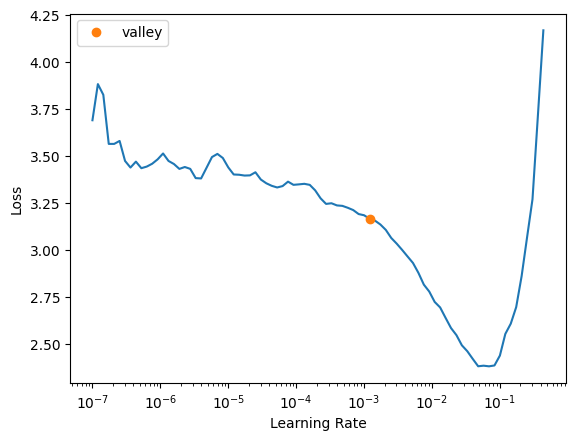

In [ ]:
from fastai.callback.tracker import EarlyStoppingCallback

# Kreiranje modela koristeći prethodno obučeni ResNet18
learn = vision_learner(dls, resnet18, metrics=accuracy, cbs=[EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=3)])

# Pronalaženje optimalne stope učenja
learn.lr_find()

In [ ]:
# Fine-tuning modela
learn.fine_tune(epochs=5, base_lr=0.0020892962347716093)

epoch,train_loss,valid_loss,accuracy,time
0,3.245957,1.936258,0.386364,00:28


epoch,train_loss,valid_loss,accuracy,time
0,2.140257,1.432712,0.545455,00:34
1,2.051026,0.914863,0.704545,00:35
2,1.668591,0.718248,0.772727,00:37
3,1.359878,0.654444,0.772727,00:35
4,1.200311,0.599678,0.818182,00:36


Testna preciznost: 0.1818181872367859


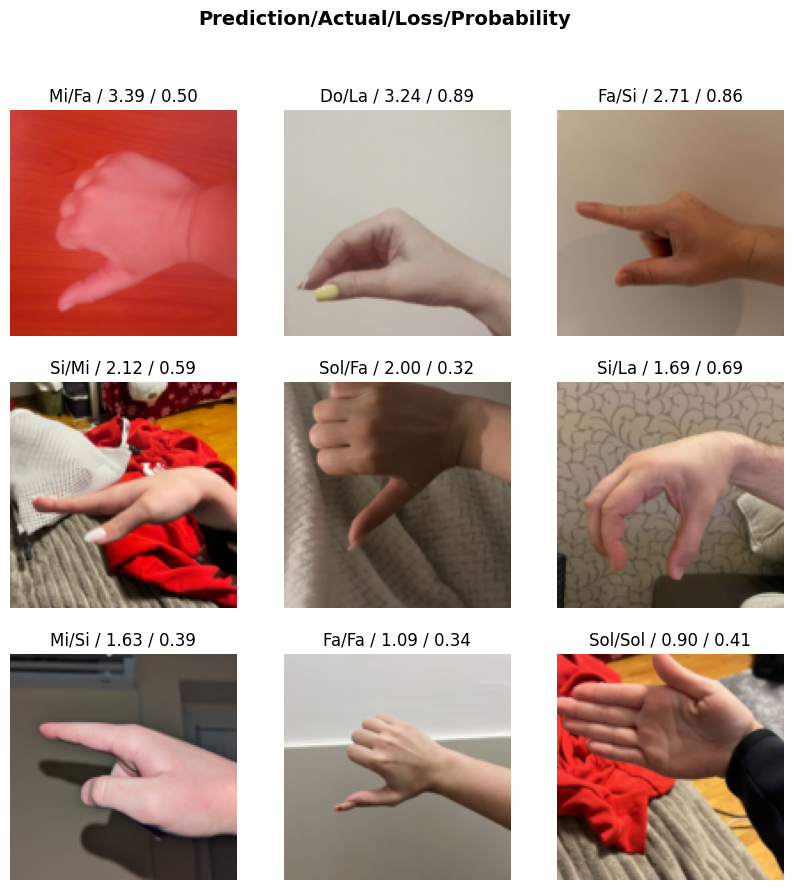

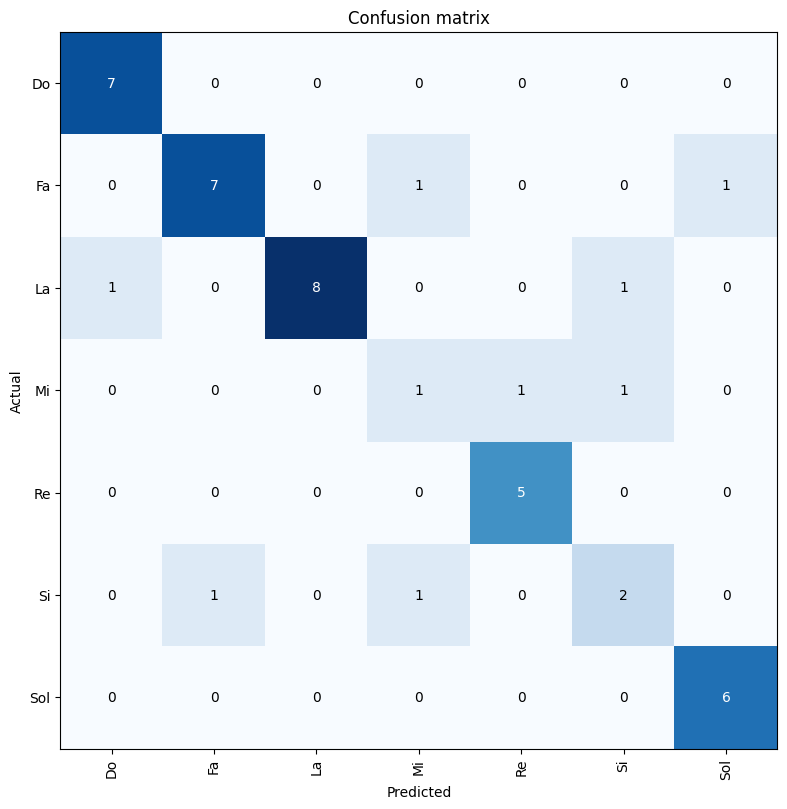

In [ ]:
# Procena performansi modela na testnom setu
test_results = learn.validate(dl=dls.valid)
print("Testna preciznost:", 1 - test_results[1])  # error_rate

# Procena performansi modela na pojedinačnim slikama
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(10,10))  # Prikazivanje najvećih gubitaka
interp.plot_confusion_matrix(figsize=(8,8))  # Prikazivanje matrice zabune

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Učitavanje slike i predikcija koristeći FastAI model
image_path = '/content/drive/MyDrive/test_set/Re/IMG_20240412_192029.jpg'
img = PILImage.create(image_path)

pred_fastai, pred_idx_fastai, probs_fastai = learn.predict(img)
print(f'Prepoznati ton (FastAI model): {pred_fastai}; Verovatnoća: {probs_fastai[pred_idx_fastai]:.2f}')


Prepoznati ton (FastAI model): Re; Verovatnoća: 0.99


In [ ]:
learn.export()

In [ ]:
# Assuming `path` is a string representing the directory path
export_file_path = os.path.join(path, 'export.pkl')
learn_inf = load_learner(export_file_path)